# House Price Data

In [1]:
import dp4gp_datasets
import dp4gp
import random
import numpy as np
import GPy
import dp4gp_histogram
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

def get_house_prices():
    #Historical, London, with qualification columns
    #Skip this if you want, and load precomputed data from the csv file below:
    #dp4gp_datasets.prepare_preloaded_prices('test.csv', boundingbox=[480e3, 130e3, 580e3, 230e3], N=10000, col_list=['QS501EW'])
    #Load precomputed dataset:
    #dataset = pd.read_csv('price_dataset10k.csv') #london, 10k purchases
    
    dp4gp_datasets.prepare_preloaded_prices('price_today_dataset10k.csv', col_list=[], since=2013, boundingbox=[480e3, 130e3, 580e3, 230e3], N=5000)
    dataset = pd.read_csv('price_today_dataset10k.csv') #london, 10k purchases
    

    #Reduce the size of the dataset and split into training and test data:
    random.seed(123)
    #dataset = dataset[dataset['years']>2014]
    #dataset = dataset.ix[random.sample(dataset.index, 200)]

    #get into useful form
    #east, north, time, education -> price
    inputs = np.vstack([dataset['easting'].values,dataset['northing'].values]).T

    #inputs = inputs[:,0:2]
    ys = dataset['price'].values
    
    return inputs, ys

def get_cloaking_prediction(training_inputs, training_ys, sens, eps, delta,noise,modvar,kernval,kern_ls,steps):
    rbf = GPy.kern.RBF(training_inputs.shape[1],kernvar, kern_ls,ARD=True)
    #rbf = GPy.kern.RBF(training_inputs.shape[1],modvar,[5e3,5e3],ARD=True)
    mod = GPy.models.GPRegression(training_inputs,training_ys,rbf)
    mod.Gaussian_noise = noise
    dpgp = dp4gp.DPGP_cloaking(mod,sens,eps,delta)
    return dpgp
    

steps = 3
eps = 1.0

inputs, ys = get_house_prices()

#FOR HOUSE PRICES
#squash data into 
ys[ys>500e3] = 500e3
ys[ys<100e3] = 100e3
sens = 400e3
kernvar = 1.0
kern_ls = np.array([1,1])*10e3

ys_mean = np.mean(ys)
ys_std = np.std(ys)
ys = ys - ys_mean
ys = ys / ys_std
sens = sens / ys_std

training_inputs = inputs[0:-100,:]
training_ys = ys[0:-100][:,None]
test_inputs = inputs[-100:,:]
test_ys = ys[-100:][:,None]

dpgp = get_cloaking_prediction(training_inputs,training_ys,sens,eps,0.01,10.0,1.0, kernvar, kern_ls, steps)
#preds, mu, cov = dpgp.draw_prediction_samples(test_inputs,1,1,1000)

warning in stationary: failed to import cython module: falling back to numpy
Creating postcode database in geo.db
geo.db exists, skipping
Using presampled dataset.
Loaded property prices.


(400, 4666)
*
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Stopped before convergence
(3.1835646372139759, 3.2552472614374586, array([[ 1.55246396]]), 1.0, 0.0)
0

 dp4gp.py:482: RuntimeWarning:covariance is not positive-semidefinite.
 /home/lionfish/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.



[ 473338.7   473338.7   473338.7   473338.7   473338.7   473338.7   473338.7
  473338.7   473338.7   473338.7   473338.7   473338.7   473338.7   473338.7
  473338.7   473338.7   473338.7   473338.7   473338.7   473338.7
  479154.68  479154.68  479154.68  479154.68  479154.68  479154.68
  479154.68  479154.68  479154.68  479154.68  479154.68  479154.68
  479154.68  479154.68  479154.68  479154.68  479154.68  479154.68
  479154.68  479154.68  484970.66  484970.66  484970.66  484970.66
  484970.66  484970.66  484970.66  484970.66  484970.66  484970.66
  484970.66  484970.66  484970.66  484970.66  484970.66  484970.66
  484970.66  484970.66  484970.66  484970.66  490786.64  490786.64
  490786.64  490786.64  490786.64  490786.64  490786.64  490786.64
  490786.64  490786.64  490786.64  490786.64  490786.64  490786.64
  490786.64  490786.64  490786.64  490786.64  490786.64  490786.64
  496602.62  496602.62  496602.62  496602.62  496602.62  496602.62
  496602.62  496602.62  496602.62  496602.

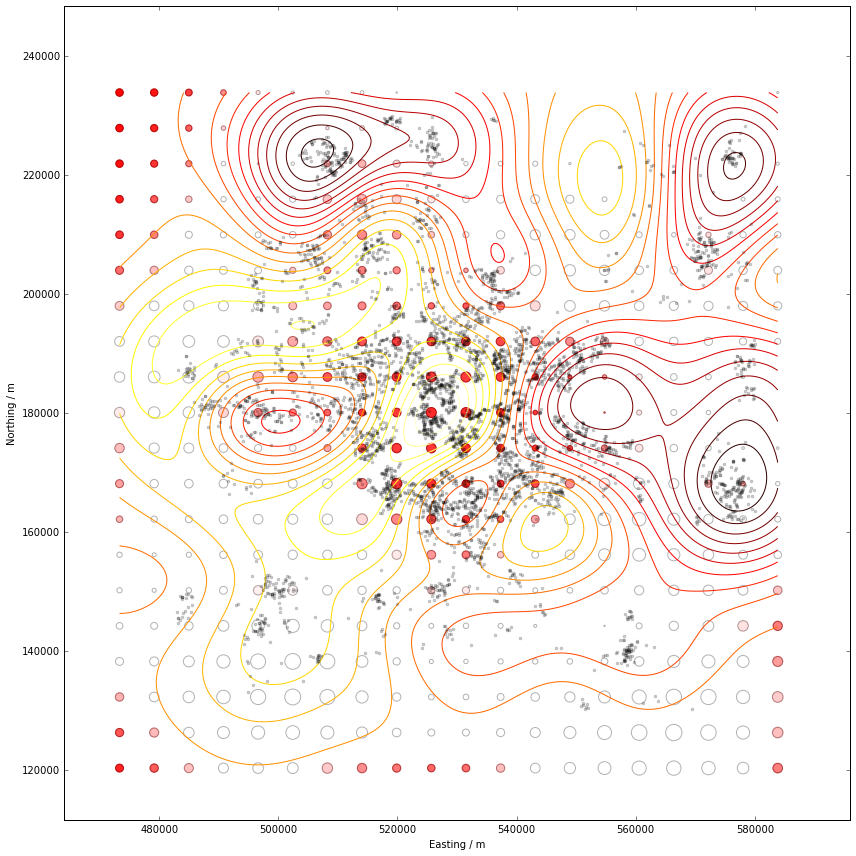

In [2]:
dpgp.plot(Nits=200,ys_std=ys_std,ys_mean=ys_mean,plotGPvar=False,plot_data=True,steps=20)
plt.xlabel('Easting / m')
plt.ylabel('Northing / m')
plt.axis('equal')
fig = plt.gcf()
fig.set_size_inches(12, 12)
plt.savefig('houseprices.pdf')